## Notebook to prep expression data
detection, sex check, normalization, and covariates

#### import libraries and notebook variables

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import random
from umap import UMAP
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import threading

In [2]:
# parameter variables
cohort = 'ppmi'
amp_abbr = 'PP'
version = 'amppdv1'
tissue = 'wb'
visits = [0, 1, 6 , 12, 18, 24, 36]
visit_names = ['BLM0T1', 'SVM0_5T1', 'SVM6T1', 'SVM12T1', 'SVM18T1', 'SVM24T1', 'SVM36T1']


In [3]:
# naming
cohort_version = f'{cohort}.{version}'
cohort_build = f'{cohort}.{tissue}'

# directories
wrk_dir = f'/labshare/raph/eqtl/{cohort}'
geno_dir = f'{wrk_dir}/genotypes'
expr_dir = f'{wrk_dir}/expression'
info_dir = f'{wrk_dir}/sample_info'

# input files
src_expression_matrix = f'/labshare/raph/datasets/amppd/expression/{amp_abbr}.all_visits.genes.hdf5'
src_sample_info = '/labshare/raph/datasets/amppd/sample_info/rna_quality_metrics.csv'
src_subject_info = '/labseq/projects/pdgenome/amppd/amppd_demographicsPlus_2019_v1release_1015.csv'
genetic_pcs_file = f'{info_dir}/{cohort}.freeze9.pca.eigenvec'
gencode_gtf = '/labshare/raph/datasets/amppd/expression/gencode.v29.primary_assembly.annotation.gtf.gz'

# output files
gencode_pkl = '/labshare/raph/datasets/amppd/expression/gencode.v29.primary_assembly.annotation.pkl'
umap_covs_file = f'{info_dir}/{cohort_build}.umap.covs.csv'
qtnorm_expr_file = f'{expr_dir}/{cohort_build}.norm.hdf5'
adj_expr_file = f'{expr_dir}/{cohort_build}.norm.adj.hdf5'


# constant values
min_expr_value = 1
# get genes where missingness exceeds 2/3rds, ie call rate >= 33%
# max_missing_rate = 0.66
max_missing_rate = 0.33
max_cov_missing_rate = 0.33

autosomes = [str(x) for x in list(range(1,23))]

#### visualization related functions

In [4]:
# function for plotting umap of traits with covar high lights
def plot_umap_clusters(umap_df, hue_cov=None, style_cov=None, size_cov=None):
    # umap_plot_file = f'{WRKDIR}/{COHORTBUILD}.umap.residuals.umap.plot.png'
    sns.set()
    plt.figure(figsize=(6,6))
    sns_plot = sns.scatterplot(x='x_umap',y='y_umap', \
                               hue=hue_cov, style=style_cov, size=size_cov, \
                               data=umap_df)
    plt.xlabel('x-umap')
    plt.ylabel('y-umap')
    #plt.legend(loc='lower right', prop={'size': 6})
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size': 6})
    # plt.savefig(umap_plot_file,format='png',dpi=600,bbox_inches='tight')
    plt.show()

# function that generate corrletion matrix from data frame and plots its heatmap    
def plot_corr_heatmap(this_df, features=None):
    sns.set()
    cor = this_df.corr(method='pearson')
    cor.dropna(how='all', inplace=True)
    if features:
        cor = cor[features]
        for feature in features:
            temp = cor[~cor.index.isin(features)]
            print(temp.sort_values(by=[feature]).head())
            print(temp.sort_values(by=[feature]).tail())            
    print(cor.shape)
    cor = cor.loc[(abs(cor['x_umap']) > 0.1) | (abs(cor['y_umap']) > 0.1)]
    print(cor.shape)
    if cor.shape[0] < 10:
        this_height = 10
    else:
        this_height = cor.shape[0]*.5
    plt.figure(figsize=(10,this_height))        
    sns.heatmap(cor, annot=True, annot_kws={"fontsize":10}, \
                linewidths=0.1, cmap='YlGnBu')    
    plt.show()
    # now find the min x and y umaps 
    cor.drop(index=['x_umap', 'y_umap'], inplace=True)
    max_value = max(abs(cor['x_umap']))
    max_x = cor.loc[(cor['x_umap'] == max_value) | 
                    ((cor['x_umap'] == -max_value))].index.values[0]
    cor.drop(index=max_x, inplace=True)
    max_value = max(abs(cor['y_umap']))
    max_y = cor.loc[(cor['y_umap'] == max_value) | 
                    ((cor['y_umap'] == -max_value))].index.values[0]
    return max_x, max_y

#### analysis related functions

In [5]:
# small function to generate umap from pandas dataframe, for all features (columns) \
# and return back as dataframe with source index intact
def generate_umap_df_from_df(this_df, rnd_digits=3, merge_input=False):
    #run UMAP on the data frame features
    umap_results = UMAP(random_state=42).fit_transform(this_df)
    umap_df = pd.DataFrame(umap_results,columns=['x_umap','y_umap'], \
                                       index=this_df.index).round(rnd_digits)
    if merge_input:
        umap_df = umap_df.merge(this_df,left_index=True,right_index=True)
    print(f'The dimensions of the umap df and the traits are {umap_df.shape}')
    return umap_df   


# function to fit linear model to covariates and calculate the standardized residuals
def covariate_residuals(traits_df, covars_df):
    lm = LinearRegression(n_jobs=16)
    residuals_df = traits_df.copy()
    covar_scores_by_trait = {}

    for trait in traits_df:
            model = lm.fit(covars_df, traits_df[trait])
            covar_scores_by_trait[trait] = model.score(covars_df,traits_df[trait])
            model_predicted = model.predict(covars_df)
            residuals_df[trait] = stats.zscore(traits_df[trait] - model_predicted)

#     #save the residuals
#     residuals_df.to_hdf(residuals_file,key='residuals',mode='w')

    #save the covariates model scores
    covar_scores_by_trait_df = pd.DataFrame.from_dict(covar_scores_by_trait, \
                                                      columns=['score'], \
                                                      orient='index').round(3)
    covar_scores_by_trait_df.index.name = 'geneID'
#     covar_scores_by_trait_df.to_csv(covars_scores_by_gene_file)

    return residuals_df, covar_scores_by_trait_df


#### create output directories

In [6]:
os.makedirs(geno_dir, exist_ok=True)
os.makedirs(expr_dir, exist_ok=True)
os.makedirs(info_dir, exist_ok=True)

#### subset genotypes to well behaved variants for running typical sample QC

#### load the sample attributes and subject info

In [7]:
# load the sample info
attrs_df = pd.read_csv(src_sample_info)
# split sample ID into wgsid and visit
temp = attrs_df['sample_id'].str.split('-', expand=True)
print(temp.shape)
attrs_df['wgsid'] = temp[0] + '-' + temp[1]
attrs_df['visit'] = temp[2]
attrs_df['cohort'] = temp[0]
attrs_df['rnaid'] = attrs_df['sample_id']
# subset sample attributes for just this cohort and visit
attrs_df = attrs_df.loc[attrs_df['cohort'] == amp_abbr]
print(attrs_df.shape)

# load the subject info
info_df = pd.read_csv(src_subject_info)
print(info_df.shape)

# now merge sample and subject info
attrs_df = attrs_df.merge(info_df, how='left', left_on='wgsid', right_on='participant_id')
attrs_df.set_index('sample_id', drop=True, inplace=True)
print(attrs_df.shape)

(8356, 3)
(4610, 18)
(4298, 16)
(4610, 33)


#### load and merge in the genetics PCs for cohort

In [8]:
genetic_components_df = pd.read_csv(genetic_pcs_file, sep='\s+', index_col=1)
genetic_components_df.drop(columns=['#FID'], inplace=True)
print(genetic_components_df.shape)
attrs_df = attrs_df.merge(genetic_components_df, how='left', left_on='wgsid', right_index=True)
print(attrs_df.shape)

(1433, 20)
(4610, 53)


In [9]:
id_map = attrs_df[['wgsid', 'rnaid']]

#### get rid of the columns that have single values or a lot missingness

In [10]:
cols_to_drop = []
for this_col in attrs_df.columns:
    drop_col = False
    try:
        percent_miss = attrs_df[this_col].isna().sum()/attrs_df.shape[0]
        if percent_miss > max_cov_missing_rate:
             drop_col = True
        else:
            total_unique = len(attrs_df[this_col].unique())
            if total_unique == 1 or total_unique == attrs_df.shape[0]:
                drop_col = True
    except:
        drop_col = True
        
    if drop_col:
        cols_to_drop.append(this_col)

        
print(cols_to_drop)

attrs_df.drop(columns=cols_to_drop, inplace=True)
print(attrs_df.shape)

['cohort', 'rnaid', 'GUID']
(4610, 50)


#### inspect some of the categorical columns

In [11]:
cats_df = attrs_df.select_dtypes(include=['object'])
for column in cats_df.columns:
    print(cats_df[column].value_counts())

1                 293
2                 212
3                 182
4                 173
5                 164
6                 129
J_RNA_11           94
J_RNA_14           93
J_RNA_3            93
J_RNA_7            93
J_RNA_6            93
J_RNA_13           93
J_RNA_17           92
20346-J_RNA_1      92
J_RNA_4            92
20346-J_RNA_2      92
J_RNA_21           92
20346-J_RNA_7      91
J_RNA_5            91
J_RNA_20           91
J_RNA_10           91
J_RNA_18           90
J_RNA_8            90
J_RNA_9            90
J_RNA_16           90
20346-J_RNA_10     90
20346-J_RNA_4      89
J_RNA_1            89
20346-J_RNA_5      89
20346-J_RNA_13     89
J_RNA_19           89
J_RNA_12           88
20346-J_RNA_12     88
7                  87
20346-J_RNA_11     86
20346-J_RNA_6      86
20346-J_RNA_14     85
20346-J_RNA_9      85
20346-J_RNA_15     85
20346-J_RNA_8      84
20346-J_RNA_3      84
J_RNA_15           79
J_RNA_22           68
20346-J_RNA_16     56
8                  49
20346-J_RN

#### generate dummies for categoricals that make sense based on inspection

In [12]:
# cat_vars_to_keep = ['SMCENTER', 'SMCENTER', 'SMGEBTCHD', 'DTHPLCE',
#                     'MHDRNKTP', 'MHDRNKPRD', 'MHSMKSTS', 'DTHSEASON']
# dums_df = pd.get_dummies(cats_df[cat_vars_to_keep], drop_first=True)
dums_df = pd.get_dummies(cats_df, drop_first=True)

attrs_df = attrs_df.merge(dums_df, how='left', left_index=True, right_index=True)

#### convert the gencode gtf to easier to read format

In [13]:
# if the gencode pickle files already exist don't regenerate it
if not os.path.isfile(gencode_pkl):
    this_cmd = f'gtf2csv --gtf {gencode_gtf} -m pkl -t $(nproc) -o {gencode_pkl}'

    print(this_cmd)
    !{this_cmd}

In [14]:
gencode_df = pd.read_pickle(gencode_pkl)
print(gencode_df.shape)

(2742734, 91)


#### load the expression matrix

In [15]:
%%time
expr_df = pd.read_hdf(src_expression_matrix, index_col=0)
print(expr_df.shape)

(4610, 58294)
CPU times: user 1.36 s, sys: 1.16 s, total: 2.52 s
Wall time: 2.53 s


#### check expected sex of samples

In [16]:
#Vawter MP, Evans S, Choudary P et al. Gender-specific gene expression in 
#post-mortem human brain: localization to sex chromosomes. 
#Neuropsychopharmacology 2004;29:373–84.

sex_specific_genes = ['XIST','RPS4Y1','RPS4Y2','KDM5D','UTY','DDX3Y','USP9Y']
sex_genes = gencode_df.loc[gencode_df['gene_name'].isin(sex_specific_genes)]
print(sex_genes.shape)

(1582, 91)


In [17]:
sex_genes['seqname'].value_counts()

chrY    1424
chrX     158
Name: seqname, dtype: int64

#### check sex of samples against reported

In [18]:
sex_genes_present = list(set(sex_genes['gene_id'].values) & set(expr_df.columns))
expr_sex_df = expr_df[sex_genes_present]
print(expr_sex_df.shape)

(4610, 7)


In [22]:
# %%time
sex_umap_df = generate_umap_df_from_df(expr_sex_df)

The dimensions of the umap df and the traits are (4610, 2)


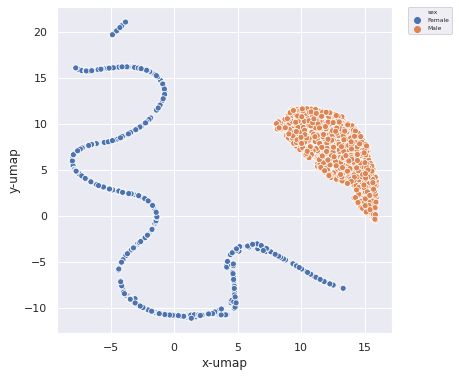

In [23]:
sex_umap_df = sex_umap_df.merge(attrs_df, how='left', left_index=True,
                                right_index=True)

plot_umap_clusters(sex_umap_df, hue_cov='sex')

In [20]:
print(sex_umap_df.loc[(sex_umap_df['x_umap'] > 5) & (sex_umap_df['sex'] == 'Male')].shape)
print(sex_umap_df.loc[(sex_umap_df['x_umap'] < 5) & (sex_umap_df['sex'] == 'Female')].shape)

(0, 137)
(0, 137)


#### double check the age range to make sure no young subjects

In [24]:
attrs_df['age_at_baseline'].describe()

count    4610.000000
mean       61.475271
std        10.888971
min        19.000000
25%        55.000000
50%        63.000000
75%        69.000000
max        90.000000
Name: age_at_baseline, dtype: float64

#### drop the know bad samples

In [25]:
# len(set(bad_samples.index) & set(expr_df.index))

In [26]:
# # now drop the know bad samples
# bad_samples.head()
# print(expr_df.shape)
# expr_df = expr_df.loc[~expr_df.index.isin(bad_samples.index)]
# print(expr_df.shape)

#### look at detection rates

In [27]:
print(f'minimun TPM value is {min_expr_value}')

detected_df = expr_df.mask(expr_df < min_expr_value, 0)

# calculate the missing counts from the detected df mask
trait_missing_rates = round(detected_df.isin({0}).sum(0)/detected_df.shape[0], 2)
sample_missing_rates = round(detected_df.isin({0}).sum(1)/detected_df.shape[1], 2)

print(len(trait_missing_rates))
print(trait_missing_rates.mean())
print(len(sample_missing_rates))
print(sample_missing_rates.mean())

minimun TPM value is 1
58294
0.6659937557896606
4610
0.6658980477223415


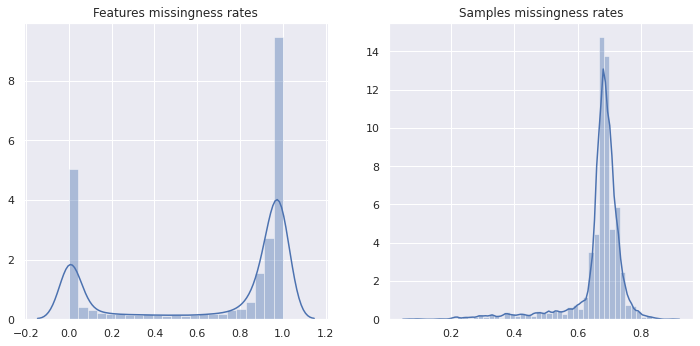

In [28]:
sns.set()
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.distplot(trait_missing_rates.values)
plt.title('Features missingness rates')
plt.subplot(2, 2, 2)
sns.distplot(sample_missing_rates.values)
plt.title('Samples missingness rates')
plt.show()

#### find genes with poor call-rates

In [29]:
bad_call_rates = trait_missing_rates[trait_missing_rates > max_missing_rate]
print(bad_call_rates.shape)
print(bad_call_rates.shape[0]/expr_df.shape[1])

(41512,)
0.7121144543177685


#### add the sample missingness rate as covariate

In [30]:
attrs_df['misrate'] = sample_missing_rates

In [78]:
# temp = attrs_df['misrate'].apply(stats.zscore)
# temp
temp = stats.zscore(attrs_df['misrate'])
stats.describe(temp)

DescribeResult(nobs=4610, minmax=(-6.759603960039242, 2.6555490317805206), mean=-4.0073993773888513e-17, variance=1.0002169668040792, skewness=-2.7298969396571127, kurtosis=9.115234270782569)

#### subset df to well detected (wd) features

In [31]:
detected_traits = list(set(expr_df.columns)-set(bad_call_rates.index))
quants_wd_df = expr_df[detected_traits]
print(quants_wd_df.shape)

(4610, 16782)


#### recheck call-rates

In [32]:
# see how well each trait is expressed
print(f'minimun TPM value is {min_expr_value}')

detected_df = quants_wd_df.mask(quants_wd_df < min_expr_value, 0)

# calculate the missing counts from the detected df mask
trait_missing_rates = round(detected_df.isin({0}).sum(0)/detected_df.shape[0], 2)
sample_missing_rates = round(detected_df.isin({0}).sum(1)/detected_df.shape[1], 2)

print(len(trait_missing_rates))
print(trait_missing_rates.mean())
print(len(sample_missing_rates))
print(sample_missing_rates.mean())

minimun TPM value is 1
16782
0.04118281492074668
4610
0.04163557483731049


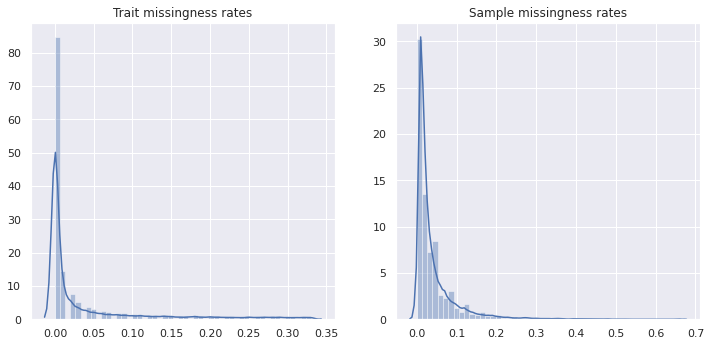

In [33]:
sns.set()
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.distplot(trait_missing_rates.values)
plt.title('Trait missingness rates')
plt.subplot(2, 2, 2)
sns.distplot(sample_missing_rates.values)
plt.title('Sample missingness rates')
plt.show()

#### normalize the traits

In [34]:
%%time

scaledX = preprocessing.quantile_transform(quants_wd_df, axis=0, copy=True,
                                           output_distribution='normal')
traits_qtnorm_df = pd.DataFrame(data=scaledX, columns=quants_wd_df.columns,
                                index=quants_wd_df.index)

CPU times: user 51.2 s, sys: 235 ms, total: 51.5 s
Wall time: 51.5 s


#### save the quantile normalized expression matrix

In [35]:
%%time 

traits_qtnorm_df.to_hdf(qtnorm_expr_file, key='expression', mode='w')

CPU times: user 568 ms, sys: 540 ms, total: 1.11 s
Wall time: 2.43 s


#### take a look at the normalized data

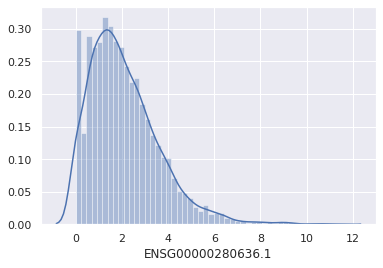

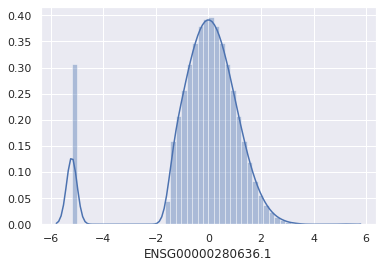

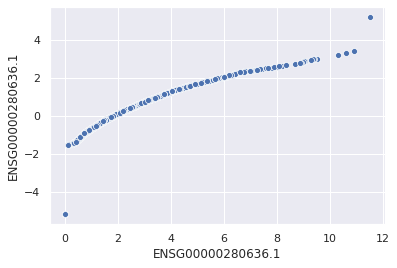

In [36]:
# spot check one of the genes
trait = random.sample(list(quants_wd_df.columns), 1)[0]

sns.distplot(quants_wd_df[trait])
plt.show()
sns.distplot(traits_qtnorm_df[trait])
plt.show()
sns.scatterplot(x=quants_wd_df[trait], y=traits_qtnorm_df[trait])

In [37]:
%%time

umap_df = generate_umap_df_from_df(traits_qtnorm_df)
umap_df = umap_df.merge(attrs_df, how='left', left_index=True, right_index=True)

The dimensions of the umap df and the traits are (4610, 2)
CPU times: user 31.1 s, sys: 872 ms, total: 32 s
Wall time: 29 s


#### what are the post normalization umap variable correlated with

               x_umap    y_umap
misrate     -0.505130 -0.758598
Box_J_RNA_3 -0.288106 -0.099082
Plate_P103  -0.288106 -0.099082
Box_J_RNA_6 -0.232385 -0.066527
Plate_P106  -0.232385 -0.066527
                                  x_umap    y_umap
Box_J_RNA_1                     0.150167 -0.029824
Concentration                   0.181266  0.295632
Plate_P220                      0.188639 -0.006159
Box_4                           0.189004  0.035975
Normalization_Volume__30ng_ul_  0.232933  0.257873
                         x_umap    y_umap
misrate               -0.505130 -0.758598
RIN_Value             -0.014001 -0.427848
Submitted_Volume__ul_ -0.201744 -0.217294
Total_Volume__ul_     -0.100690 -0.100888
Plate_P103            -0.288106 -0.099082
                                  x_umap    y_umap
race_White                      0.034544  0.097652
Input_miRNA__ng_                0.071704  0.100884
Input_RNASeq__ng_               0.071704  0.100884
Normalization_Volume__30ng_ul_  0.232933  0.25

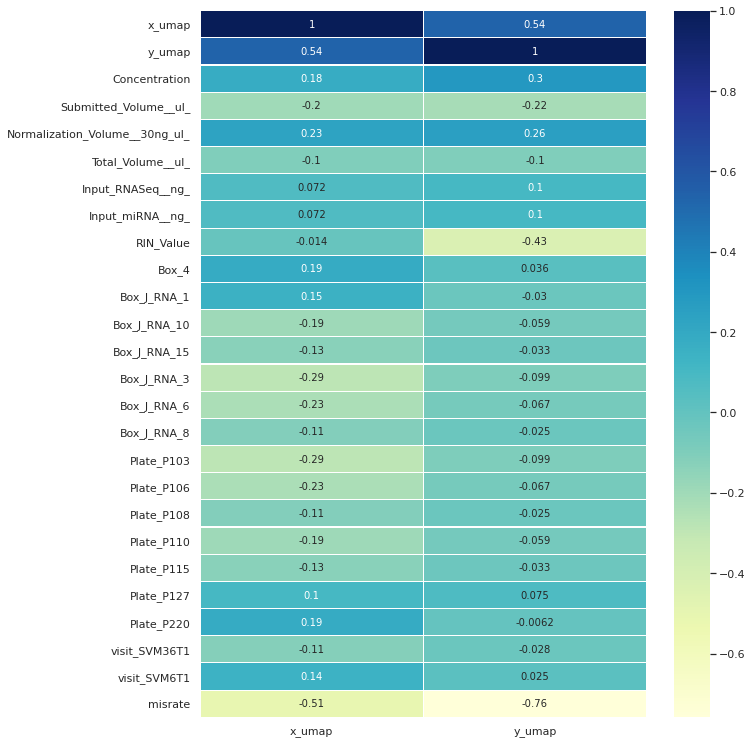

In [38]:
most_x_umap, most_y_umap = plot_corr_heatmap(umap_df, features=['x_umap', 'y_umap'])

misrate RIN_Value


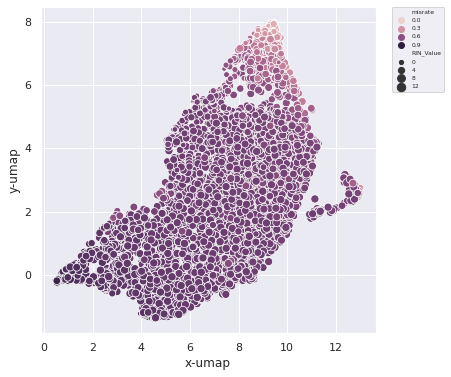

In [39]:
print(most_x_umap, most_y_umap)
plot_umap_clusters(umap_df, hue_cov=most_x_umap, size_cov=most_y_umap)

#### exclude low variance genes from covariate generation

In [40]:
quants_vars = traits_qtnorm_df.var() 
print(quants_vars.describe())
# drop genes within the lower quartile of variance
min_variance = quants_vars.describe()['25%']
# min_variance = quants_vars.describe()['50%']
keep = quants_vars[quants_vars > min_variance]
print(keep.shape)
print(traits_qtnorm_df.shape)
quants_wd_var_df = traits_qtnorm_df[list(keep.index)]
print(quants_wd_var_df.shape)

count    16782.000000
mean         1.086952
std          0.487825
min          1.005569
25%          1.006814
50%          1.007308
75%          1.008090
max          7.329758
dtype: float64
(12586,)
(4610, 16782)
(4610, 12586)


#### take a look at the data

In [41]:
%%time

umap_df = generate_umap_df_from_df(quants_wd_var_df)
umap_df = umap_df.merge(attrs_df, how='left', left_index=True, right_index=True)

The dimensions of the umap df and the traits are (4610, 2)
CPU times: user 28.4 s, sys: 670 ms, total: 29 s
Wall time: 26.2 s


In [42]:
# calculate the standard z-scores
umap_z_df = umap_df[['x_umap', 'y_umap']].apply(stats.zscore)
print(umap_z_df.describe())

             x_umap        y_umap
count  4.610000e+03  4.610000e+03
mean   7.936080e-08  3.456439e-08
std    1.000108e+00  1.000108e+00
min   -2.438018e+00 -1.806639e+00
25%   -7.218123e-01 -8.366398e-01
50%   -1.166404e-01 -9.756017e-02
75%    6.481982e-01  7.094170e-01
max    2.749659e+00  2.485942e+00


#### see what the umaps are correlated with known covariate-wise

                                  x_umap    y_umap
Normalization_Volume__30ng_ul_ -0.223868  0.263670
Plate_P220                     -0.199869 -0.009501
Box_4                          -0.196083  0.038107
Concentration                  -0.164245  0.296429
Box_J_RNA_1                    -0.157208 -0.038797
               x_umap    y_umap
Plate_P106   0.248518 -0.087875
Box_J_RNA_6  0.248518 -0.087875
Box_J_RNA_3  0.291383 -0.108377
Plate_P103   0.291383 -0.108377
misrate      0.454692 -0.757660
                         x_umap    y_umap
misrate                0.454692 -0.757660
RIN_Value             -0.016598 -0.411647
Submitted_Volume__ul_  0.195408 -0.221836
Plate_P103             0.291383 -0.108377
Box_J_RNA_3            0.291383 -0.108377
                                  x_umap    y_umap
race_White                     -0.026070  0.096837
Input_miRNA__ng_               -0.069259  0.099576
Input_RNASeq__ng_              -0.069259  0.099576
Normalization_Volume__30ng_ul_ -0.223868  0.26

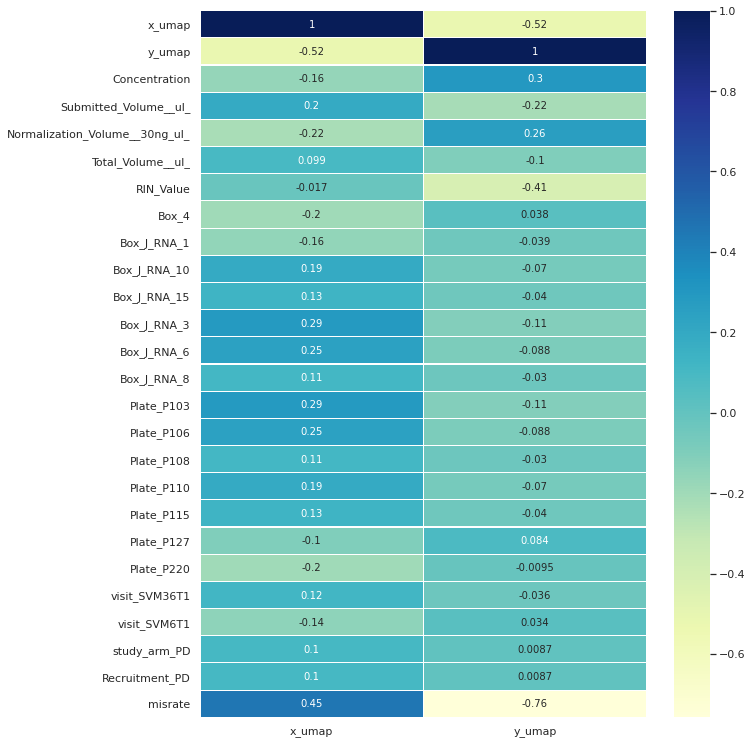

In [43]:
most_x_umap, most_y_umap = plot_corr_heatmap(umap_df, features=['x_umap', 'y_umap'])

misrate RIN_Value


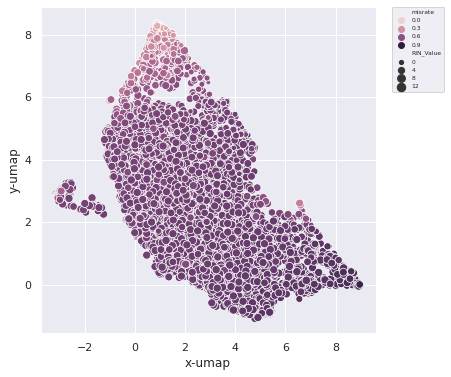

In [44]:
print(most_x_umap, most_y_umap)
plot_umap_clusters(umap_df, hue_cov=most_x_umap, size_cov=most_y_umap)

In [45]:
# with pd.option_context('display.max_seq_items', None):
#     print (umap_df.columns)

#### keep created covars and save them

In [46]:
covs_df = umap_df[['x_umap', 'y_umap']]
covs_df.to_csv(umap_covs_file)

#### covariate adjust the normalized data by the covariates

In [47]:
# check to see in df's have same indices
if not traits_qtnorm_df.index.equals(covs_df.index):
    print('indices are not equal re-index')
    covs_df.reindex(traits_qtnorm_df.index)
    
traits_qtnorm_df.index.equals(covs_df.index)    

True

In [48]:
%%time

residuals_df, cov_scores_df = covariate_residuals(traits_qtnorm_df, covs_df)

#take a peek at the data
print(residuals_df.shape)
print(cov_scores_df.shape)

print(cov_scores_df.head())

(4610, 16782)
(16782, 1)
                    score
geneID                   
ENSG00000115661.13  0.327
ENSG00000177917.10  0.553
ENSG00000211663.2   0.176
ENSG00000259345.6   0.560
ENSG00000157106.16  0.707
CPU times: user 20min 29s, sys: 1min 33s, total: 22min 2s
Wall time: 1min 50s


In [49]:
# get a summary of the covariates model scores
cov_scores_df.describe()

,score
count,16782.000000
mean,0.533639
std,0.198027
min,0.000000
25%,0.405000
50%,0.571000
75%,0.691000
max,0.898000


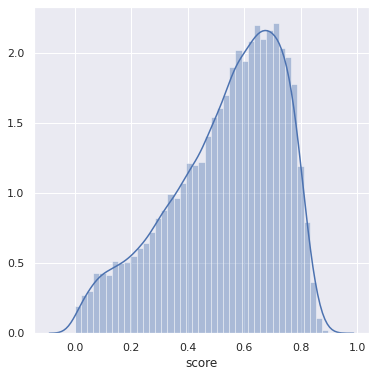

In [50]:
# look at the distribution of covariate model scores, 
# ie get a sense any gene driven by covariates
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(cov_scores_df['score'])
plt.show()

#### save quantile normalized and covariate adjusted data

In [51]:
%%time 

residuals_df.to_hdf(adj_expr_file, key='expression', mode='w')

CPU times: user 531 ms, sys: 545 ms, total: 1.08 s
Wall time: 2.33 s


#### take a look at the normalized and covariate adjusted data

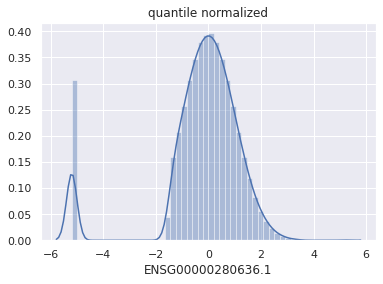

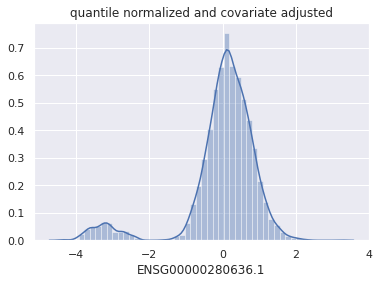

Text(0, 0.5, 'after covariate adjusted')

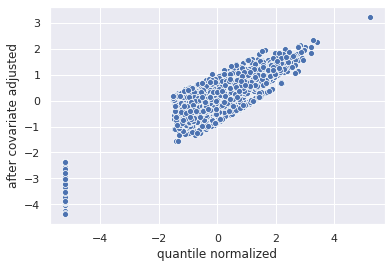

In [52]:
# spot check same gene as before 
sns.distplot(traits_qtnorm_df[trait])
plt.title('quantile normalized')
plt.show()
sns.distplot(residuals_df[trait])
plt.title('quantile normalized and covariate adjusted')
plt.show()
sns.scatterplot(x=traits_qtnorm_df[trait], y=residuals_df[trait])
plt.xlabel('quantile normalized')
plt.ylabel('after covariate adjusted')

                    score
geneID                   
ENSG00000124155.17  0.898


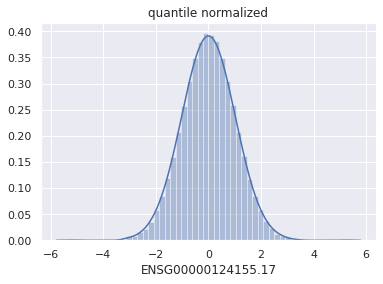

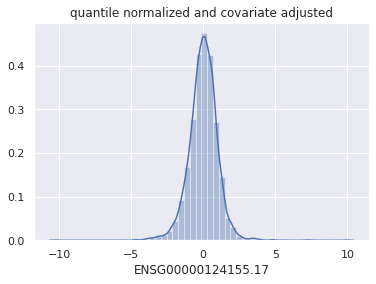

Text(0, 0.5, 'after covariate adjusted')

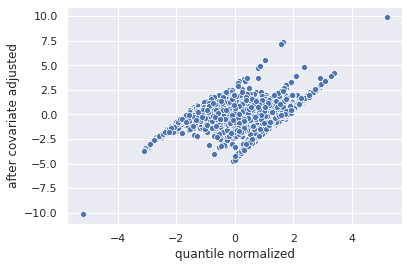

In [53]:
# find gene with largest score
large_adj_trait = cov_scores_df.loc[cov_scores_df['score'] == max(cov_scores_df['score'])]
print(large_adj_trait)
large_adj_traid_id = large_adj_trait.index.values[0]

# spot check same gene as before 

sns.distplot(traits_qtnorm_df[large_adj_traid_id])
plt.title('quantile normalized')
plt.show()
sns.distplot(residuals_df[large_adj_traid_id])
plt.title('quantile normalized and covariate adjusted')
plt.show()
sns.scatterplot(x=traits_qtnorm_df[large_adj_traid_id],
                y=residuals_df[large_adj_traid_id])
plt.xlabel('quantile normalized')
plt.ylabel('after covariate adjusted')

#### what are the post normalization and covariate adjusted umap variables correlated with

In [54]:
%%time

umap_df = generate_umap_df_from_df(residuals_df)
umap_df = umap_df.merge(attrs_df, how='left', left_index=True, right_index=True)

The dimensions of the umap df and the traits are (4610, 2)
CPU times: user 35.7 s, sys: 947 ms, total: 36.7 s
Wall time: 34.1 s


                                            x_umap    y_umap
misrate                                  -0.334046 -0.300732
Box_J_RNA_1                              -0.145390  0.165465
Plate_P220                               -0.121380  0.086833
Box_4                                    -0.115185  0.037056
education_level_years_Less than 12 years -0.092855 -0.004287
                                                      x_umap    y_umap
prodromal_category_Unknown/Not collected as enr...  0.059596  0.048043
Total_Volume__ul_                                   0.070887 -0.003807
diagnosis_latest_No PD Nor Other Neurological D...  0.071952  0.079381
case_control_other_latest_Control                   0.071952  0.079381
RIN_Value                                           0.090468 -0.045653
                                 x_umap    y_umap
misrate                       -0.334046 -0.300732
age_at_baseline               -0.061053 -0.115460
race_White                    -0.041485 -0.067955
study_ar

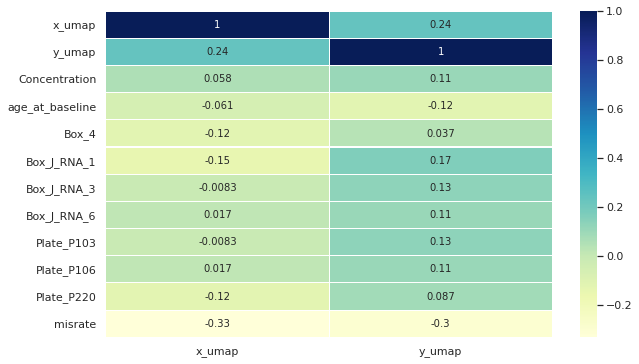

In [55]:
most_x_umap, most_y_umap = plot_corr_heatmap(umap_df, features=['x_umap', 'y_umap'])

misrate Box_J_RNA_1


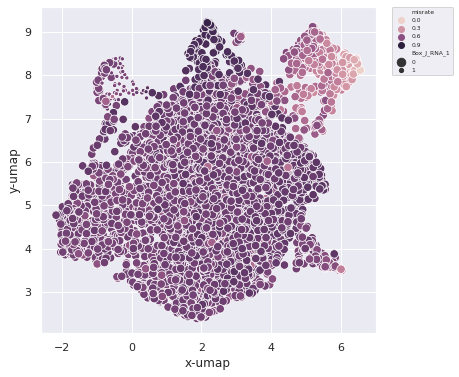

In [56]:
print(most_x_umap, most_y_umap)
plot_umap_clusters(umap_df, hue_cov=most_x_umap, size_cov=most_y_umap)

#### save the final prepped expression data as plink2 pheno files

In [54]:
%%time

def write_chrom_pheno_data(this_df, chrom, gencode_df, file_name, id_map):
    chrom_gencode_df =  gencode_df.loc[gencode_df['seqname'] == f'chr{chrom}', ['gene_id']]
    chrom_genes_present = list(set(chrom_gencode_df['gene_id']) & set(this_df.columns))
    chrom_df = this_df[chrom_genes_present].copy()
    # plink will expect FID and IID columns go ahea and add here
    chrom_df = chrom_df.merge(id_map, how='left', left_index=True, right_index=True)
    chrom_df.insert( 0, column="FID", value=chrom_df['wgsid'])
    chrom_df.insert( 1, column="IID", value=chrom_df['wgsid'])
    chrom_df.drop(columns=['wgsid', 'rnaid'], inplace=True)
    print(f'chr{chrom} {chrom_df.shape}')
    chrom_df.to_csv(file_name, index=False, header=True, sep='\t')


#go ahead and subset gencode annots to just thos present in data
gencode_present_df = gencode_df.loc[gencode_df['gene_id'].isin(residuals_df.columns)]
job_threads = []
for chrom in autosomes:
    out_file = f'{expr_dir}/{cohort_build}.chr{chrom}.pheno'
    this_thread = threading.Thread(target=write_chrom_pheno_data,
                                   args=(residuals_df, chrom, gencode_present_df, out_file, id_map))
    job_threads.append(this_thread)
    this_thread.start()

for job_thread in job_threads:
    job_thread.join()    

chr13 (853, 326)
chr5 (853, 765)
chr18 (853, 298)
chr1 (853, 1685)
chr6 (853, 878)
chr9 (853, 659)
chr10 (853, 636)
chr8 (853, 609)
chr4 (853, 653)
chr2 (853, 1173)
chr19 (853, 1085)
chr21 (853, 200)
chr20 (853, 416)
chr3 (853, 949)
chr16 (853, 804)
chr11 (853, 907)
chr22 (853, 398)
chr15 (853, 613)
chr7 (853, 876)
chr14 (853, 708)
chr17 (853, 1060)
chr12 (853, 974)
CPU times: user 45.8 s, sys: 4.25 s, total: 50 s
Wall time: 47.3 s


In [57]:
covs_df.head()

,x_umap,y_umap
PP-3867-SVM6T1,4.751,-0.137
PP-3115-SVM6T1,1.726,2.985
PP-3604-SVM12T1,2.599,3.450
PP-3522-SVM12T1,3.796,4.613
PP-50572-SVM12T1,4.257,5.029


In [64]:
bl_covs = pd.read_csv(f'{info_dir}/{cohort}.wb24.umap.covs.csv', index_col=0)
print(bl_covs.shape)
bl_covs.head()

(831, 2)


,x_umap,y_umap
PP-60044-SVM24T1,2.380,4.216
PP-3060-SVM24T1,-0.214,2.929
PP-3460-SVM24T1,-0.976,4.866
PP-3226-SVM24T1,-2.115,5.068
PP-40592-SVM24T1,0.438,2.172


In [65]:
merged = pd.merge(covs_df, bl_covs, how='inner', left_index=True, right_index=True)
print(merged.shape)
merged.head()

(831, 4)


,x_umap_x,y_umap_x,x_umap_y,y_umap_y
PP-60044-SVM24T1,3.471,4.570,2.380,4.216
PP-3060-SVM24T1,0.185,4.404,-0.214,2.929
PP-3460-SVM24T1,1.593,6.932,-0.976,4.866
PP-3226-SVM24T1,0.722,7.519,-2.115,5.068
PP-40592-SVM24T1,0.126,2.778,0.438,2.172


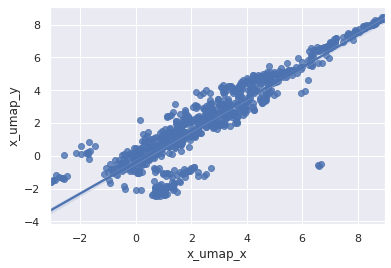

In [67]:
sns.regplot(x='x_umap_x', y='x_umap_y', data=merged)

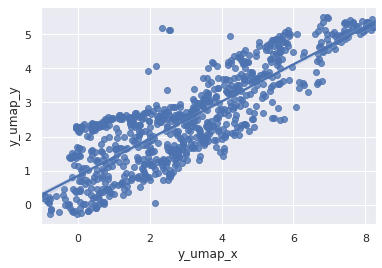

In [68]:
sns.regplot(x='y_umap_x', y='y_umap_y', data=merged)